# *FaunaScope*

**Autor:** Juan Carlos Ramírez Gil  
**Fecha:** 7 de noviembre de 2025  
**Proyecto:** AVES_MAMIFEROS 
**Software:** Python 3.14 + Jupyter Notebook  
---


# Introduccion

Este código corresponde a u análisis estadístico de la diversidad par aves y mamíferos en la parte alta de cuenca del rio zulia en el departamento de norte de Santander como parte de una prestacion de servicios profesionales en Biologia (Fauna), el siguiente código integra Python desde visual code  para crear un código de análisis reproducible y moderno que permita ahorrar el trabajo de análisis en proyectos futuros.

## Crear repositorio en GitHub para guardar el proyecto

El proyecto sera guardado en un repositorio de github para poder darle trazabilidad al mismo y compartirlo libremente la siguiente linea de codigo permite guardarlo en automatico ejecutando #### auto_commit.py


In [ ]:
import subprocess
from datetime import datetime

def ejecutar_comando(comando):
    """Ejecuta un comando del sistema y muestra la salida en consola."""
    try:
        resultado = subprocess.run(
            comando,
            check=True,
            text=True,
            capture_output=True
        )
        print(resultado.stdout)
    except subprocess.CalledProcessError as e:
        print(f"⚠️ Error ejecutando comando: {comando}")
        print(e.stderr)

def auto_commit():
    """Agrega, commitea y sube los cambios automáticamente al repositorio."""
    
    # 🕒 1️⃣ Generar mensaje con fecha y hora
    fecha = datetime.now().strftime("%Y-%m-%d %H:%M:%S")
    mensaje = f"Auto-commit: actualización {fecha}"

    print("🔍 Verificando estado del repositorio...")
    ejecutar_comando(["git", "status"])

    print("➕ Agregando todos los cambios al área de preparación...")
    ejecutar_comando(["git", "add", "."])

    print(f"💾 Realizando commit con mensaje: '{mensaje}'")
    ejecutar_comando(["git", "commit", "-m", mensaje])

    print("🚀 Subiendo cambios al repositorio remoto (rama master)...")
    ejecutar_comando(["git", "push", "origin", "master"])


# Analisis de datos
Hay que recordar que se trabajara desde python, utilizando pandas y leyendo archivos xlsx, para esto se aplicar un paquete especifico que lea el documento

In [ ]:
#--------------## Cargar librerias necesarias------------------------------

# Si no las tienes instaladas, ejecuta esta celda una vez:
# Salir del interprete con: exit()

# !pip install pandas numpy matplotlib tabulate openpyxl

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tabulate import tabulate
import openpyxl

#--------------## Leer archivo ------------------------------
# Ruta del archivo
ruta = r"D:\CORPONOR 2025\Backet\python_Proyect\data\POF_ZULIA_2025_BD_AVES_MAMIFEROS.xlsx"

# Leer el archivo Excel
Registros = pd.read_excel(ruta)

# Mostrar las primeras filas
print("📄 Primeras filas del archivo:")
print(Registros.head())

# Mostrar nombres de las columnas
print("\n📋 Columnas del DataFrame:")
print(Registros.columns)


# Metodologia


A continuación, se describen los análisis realizados sobre la información obtenida durante el muestreo de fauna.


## Esfuerzo de Muestreo
El esfuerzo de muestreo (E) se estimó de acuerdo con la metodología empleada y las características del grupo taxonómico evaluado, considerando la relación entre el número de unidades de muestreo, el tiempo efectivo de muestreo y, cuando aplicó, el número de observadores o dispositivos utilizados. En términos generales, el esfuerzo se calculó multiplicando el número de unidades de muestreo (trampas, redes, cámaras, transectos o puntos de observación) por el tiempo de exposición o duración de cada sesión de muestreo (horas, días o noches), ajustado al número de personas o equipos activos en campo. Esta aproximación permite estandarizar la intensidad del muestreo entre diferentes métodos y grupos biológicos, facilitando la comparación de resultados y la estimación del éxito de muestreo (Em), definido como la razón entre el número total de registros obtenidos y el esfuerzo total aplicado para cada técnica.

##### En primera instancia se revisa el contenido de las columas a utilizar en el analisis

In [ ]:
#--------------## Leer archivo y revisar columnas------------------------------
# Ruta del archivo
ruta = r"D:\CORPONOR 2025\Backet\python_Proyect\data\POF_ZULIA_2025_BD_AVES_MAMIFEROS.xlsx"

# Leer el archivo Excel
Registros = pd.read_excel(ruta)

# Mostrar las primeras filas
print("📄 Primeras filas del archivo:")
print(Registros.head())

# Mostrar nombres de las columnas
print("\n📋 Columnas del DataFrame:")
print(Registros.columns)

# Mostrar valores únicos de algunas columnas
for col in ["METODOLOGIA", "METODO", "ID", "Gremio"]:
    if col in Registros.columns:
        print(f"\n🔹 Valores únicos en '{col}':")
        print(Registros[col].unique())
    else:
        print(f"\n⚠️ La columna '{col}' no existe en el DataFrame.")

#### Crear tabla de esfuerzo de muestreo

In [ ]:
#--------------## Esfuerzo de Muestreo------------------------------

import pandas as pd
from tabulate import tabulate

# --- Copiar dataframe base ---
df = Registros.copy()

# --- Normalizar texto ---
df['METODO'] = df['METODO'].astype(str).str.strip()
df['COBERTURA'] = df['COBERTURA'].astype(str).str.strip()
df['ID'] = df['ID'].astype(str).str.strip()

# --- Diccionario de abreviaciones de coberturas ---
abreviaciones_cobertura = {
    'Bosque De Galería Y Ripario': 'Bgr',
    'Bosque De Galeria Y Ripario': 'Bgr',
    'Bosque Denso Alto De Tierra Firme': 'Bda',
    'Bosque Denso Bajo De Tierra Firme': 'Bdb',
    'Bosque Fragmentado Con Vegetación Secundaria': 'Bfvs',
    'Bosque Fragmentado Con Vegetacion Secundaria': 'Bfvs',
    'Sin Dato': 'NA'
}

# --- Aplicar reemplazos (con control de mayúsculas y tildes) ---
df['COBERTURA'] = df['COBERTURA'].apply(
    lambda x: abreviaciones_cobertura.get(x.strip().title(), x)
)

# --- Reemplazar vacíos y nulos por 'Sin dato' ---
df['METODO'] = df['METODO'].replace('', 'Sin dato').fillna('Sin dato')
df['COBERTURA'] = df['COBERTURA'].replace('', 'Sin dato').fillna('Sin dato')


# --- Validar que exista la nueva columna de horas ---
if 'Hora_Hombre' not in df.columns:
    raise ValueError('❌ La columna Hora_Hombre no existe en el dataframe Registros.')

# --- Calcular totales de individuos (sin perder registros) ---
individuos = (
    df.groupby(['METODO', 'COBERTURA'], dropna=False, as_index=False)['INDIVIDUOS']
      .sum(min_count=1)
)

# --- Calcular esfuerzo total único por ID ---
# (Evitamos duplicar horas si un ID aparece varias veces)
esfuerzo_unico = df[['ID', 'METODO', 'COBERTURA', 'Hora_Hombre']].drop_duplicates()

# --- Calcular esfuerzo total (solo una vez por ID) ---
esfuerzo = (
    esfuerzo_unico.groupby(['METODO', 'COBERTURA'], dropna=False, as_index=False)['Hora_Hombre']
    .sum(min_count=1)
    .rename(columns={'Hora_Hombre': 'Esfuerzo_horas'})
)


# --- Unir tablas ---
tabla = individuos.merge(esfuerzo, on=['METODO', 'COBERTURA'], how='outer')
tabla['Exito_captura'] = tabla['INDIVIDUOS'] / tabla['Esfuerzo_horas']

# --- Calcular totales por método ---
totales = tabla.groupby('METODO', as_index=False).agg({
    'INDIVIDUOS': 'sum',
    'Esfuerzo_horas': 'sum'
})
totales['Exito_captura'] = totales['INDIVIDUOS'] / totales['Esfuerzo_horas']
totales['COBERTURA'] = 'Total'

# --- Unir con la tabla principal ---
tabla_final = pd.concat([tabla, totales], ignore_index=True)

# --- Reestructurar para salida ---
tabla_melt = pd.melt(
    tabla_final,
    id_vars=['METODO', 'COBERTURA'],
    value_vars=['INDIVIDUOS', 'Esfuerzo_horas', 'Exito_captura'],
    var_name='Indice',
    value_name='Valor'
)

# --- Cambiar nombres de los índices ---
tabla_melt['Indice'] = tabla_melt['Indice'].replace({
    'INDIVIDUOS': 'Número de individuos',
    'Esfuerzo_horas': 'Esfuerzo captura (horas-hombre)',
    'Exito_captura': 'Éxito de captura (individuos/horas-hombre)'
})


# --- Orden lógico de los índices ---
orden_indices = [
    'Número de individuos',
    'Esfuerzo captura (horas-hombre)',
    'Éxito de captura (individuos/horas-hombre)'
]
tabla_melt['Indice'] = pd.Categorical(tabla_melt['Indice'], categories=orden_indices, ordered=True)

# --- Renombrar columna ---
tabla_melt = tabla_melt.rename(columns={'METODO': 'Metodologia'})

# --- Orden personalizado de metodologias ---
orden_metodologia = [
    'Transecto',
    'Punto de observacion',
    'Red de niebla',
    'Camara Trampa',
    'Informacion Secundaria'
]

tabla_melt['Metodologia'] = pd.Categorical(tabla_melt['Metodologia'], categories=orden_metodologia, ordered=True)

# --- Orden personalizado de Metodologias ---
orden_COBERTURA = [
    'Bgr',
    'Bfvs',
    'Bda',
    'Bdb',
    'Total'
]

tabla_melt['COBERTURA'] = pd.Categorical(tabla_melt['COBERTURA'], categories=orden_COBERTURA, ordered=True)

# --- Pivotar ---
tabla_pivot = tabla_melt.pivot_table(
    index=['Metodologia', 'Indice'],
    columns='COBERTURA',
    values='Valor',
    aggfunc='first'
).reset_index()

# --- Redondear ---
tabla_pivot = tabla_pivot.round(3)

# --- Mostrar resumen en consola ---
print(tabulate(tabla_pivot, headers='keys', tablefmt='fancy_grid', floatfmt='.3f'))


# --- Exportar a Excel a una ruta específica ---
import os

# Definir la ruta exacta donde guardar el archivo
output_path = r"D:\CORPONOR 2025\Backet\python_Proyect\Resultados"
output_file = os.path.join(output_path, "Esfuerzo_Muestreo.xlsx")

# Exportar el DataFrame a Excel
tabla_pivot.to_excel(output_file, index=False)

# Confirmar la ubicación del archivo guardado
print(f"✅ Archivo exportado correctamente en:\n{output_file}")

#### Dar Formato a la tabla exportada

In [ ]:
#---------------Dar formato a archivo generato o tabla---------------


from openpyxl import load_workbook
from openpyxl.styles import PatternFill, Alignment, Font, Border, Side
from openpyxl.utils import get_column_letter
import os

# --- Nombre del archivo a formatear ---
output_file = r"D:\CORPONOR 2025\Backet\python_Proyect\Resultados\Esfuerzo_Muestreo.xlsx"

# --- Verificar que el archivo existe ---
if not os.path.exists(output_file):
    raise FileNotFoundError(f"⚠️ No se encontró el archivo: {output_file}")

# --- Cargar el archivo ---
wb = load_workbook(output_file)
ws = wb.active

# --- Estilos base ---
header_fill = PatternFill(start_color='BFD8B8', end_color='BFD8B8', fill_type='solid')
header_font = Font(bold=True, color='000000', name='Calibri')
center_align = Alignment(horizontal='center', vertical='center', wrap_text=True)

# --- Bordes finos para toda la tabla ---
thin_border = Border(
    left=Side(style='thin', color='000000'),
    right=Side(style='thin', color='000000'),
    top=Side(style='thin', color='000000'),
    bottom=Side(style='thin', color='000000')
)

# --- Aplicar formato y reemplazar vacíos ---
for row in ws.iter_rows():
    for cell in row:
        # Reemplazar vacíos o None por guion
        if cell.value is None or str(cell.value).strip() == '':
            cell.value = '-'
        # Aplicar formato general
        cell.border = thin_border
        cell.alignment = center_align

# --- Aplicar formato al encabezado ---
for cell in ws[1]:
    cell.fill = header_fill
    cell.font = header_font
    cell.alignment = center_align

# --- Ajustar ancho de columnas automáticamente ---
for col in ws.columns:
    max_length = 0
    column = get_column_letter(col[0].column)
    for cell in col:
        if cell.value:
            length = len(str(cell.value))
            if length > max_length:
                max_length = length
    ws.column_dimensions[column].width = max_length + 3

# --- Ajustar altura de filas automáticamente ---
for row in ws.iter_rows():
    max_height = 15
    for cell in row:
        if cell.value and "\n" in str(cell.value):
            lines = str(cell.value).count('\n') + 1
            if lines > 1:
                max_height = 15 * lines
    ws.row_dimensions[cell.row].height = max_height

# --- Guardar cambios ---
wb.save(output_file)
print(f'📘 Archivo formateado con éxito:\n{output_file}')


#### Mostrar archivo creado

In [1]:
import pandas as pd
from IPython.display import display, HTML

# --- Leer el archivo Excel ---
# 👇 Usa una cadena RAW (r"...") para evitar errores con las barras invertidas
tabla = pd.read_excel(r"D:\CORPONOR 2025\Backet\python_Proyect\Resultados\Esfuerzo_Muestreo.xlsx")

# --- Mostrar tabla con desplazamiento vertical ---
display(HTML(f"""
<h3>Vista del archivo <code>Esfuerzo_Muestreo.xlsx</code></h3>
<div style="
    height: 400px;
    overflow-y: scroll;
    border: 1px solid #ccc;
    padding: 8px;
    font-size: 14px;
">
{tabla.to_html(index=False)}
</div>
"""))



Metodologia,Indice,Bgr,Bfvs,Bda,Bdb,Total
Transecto,Número de individuos,160,243,1683.000,713.000,2799.000
Transecto,Esfuerzo captura (horas-hombre),12,30,108.000,78.000,228.000
Transecto,Éxito de captura (individuos/horas-hombre),13.333,8.1,15.583,9.141,12.276
Punto de observacion,Número de individuos,-,-,11.000,5.000,16.000
Punto de observacion,Esfuerzo captura (horas-hombre),-,-,6.000,2.000,8.000
Punto de observacion,Éxito de captura (individuos/horas-hombre),-,-,1.833,2.500,2.000
Red de niebla,Número de individuos,-,1,10.000,2.000,13.000
Red de niebla,Esfuerzo captura (horas-hombre),-,2,9.000,2.000,13.000
Red de niebla,Éxito de captura (individuos/horas-hombre),-,0.5,1.111,1.000,1.000
Camara Trampa,Número de individuos,-,-,17.000,68.000,85.000


## Tabla general grupo taxonomico
La tabla presenta la composición taxonómica y ecológica de las especies registradas durante el muestreo, organizadas jerárquicamente por orden, familia y especie, e incluyendo el nombre común correspondiente. Para cada especie se indica su gremio trófico, lo que permite identificar los principales grupos funcionales presentes en el área de estudio y su papel dentro de la comunidad biológica. Asimismo, se especifican las coberturas o tipos de hábitat en las que fueron registradas, el valor de abundancia relativa o número de individuos observados, y el tipo de registro obtenido (observación directa, captura, fotografía, vocalización, entre otros). Esta información permite evaluar la diversidad, la estructura trófica y el grado de representatividad de las especies en las distintas coberturas evaluadas.


In [ ]:
#------------------------Tabla general grupo taxonomico-------------------------

# Mostrar las primeras filas
print(Registros.info())


import pandas as pd

# --- Copiar el DataFrame base ---
df = Registros.copy()

# --- Normalizar texto ---
for col in ['CLASE', 'Orden', 'Familia', 'Genero', 'Epiteto', 'N. comun', 'Gremio', 'COBERTURA', 'METODOLOGIA']:
    df[col] = df[col].astype(str).str.strip().str.title()

# --- Crear nombre científico completo ---
df['Especie_cientifica'] = df['Genero'] + ' ' + df['Epiteto']

# --- Diccionario de abreviaciones de Metodologia ---
abreviaciones_metodo = {
    'Auditivo': 'Aud',
    'Fotografia': 'Fot',
    'Fotografia ': 'Fot',
    'Marcas De Presencia': 'MP',
    'Avistamiento': 'Obs',
    'Observacion': 'Obs',
    'Entrevista': 'Ent',
    'Captura': 'Cap',
    'Rastros': 'Ras',
    'Huellas': 'Hue',
    'Cueva': 'Cuv',
    'Heces': 'Hec',
    'Video': 'Vid',
    'Informacion Mcnup': 'MCNUP'
}

# --- Diccionario de abreviaciones de cobertura ---
abreviaciones_cobertura = {
    'Bosque De Galería Y Ripario': 'Bgr',
    'Bosque Denso Alto De Tierra Firme': 'Bda',
    'Bosque Denso Bajo De Tierra Firme': 'Bdb',
    'Bosque Fragmentado Con Vegetación Secundaria': 'Bfvs'
}

# --- Diccionario de abreviaciones de gremio ---
abreviaciones_gremio = {
    'Carnívoro': 'Car',
    'Nectarívoro': 'Nec',
    'Carroñero': 'Crr',
    'Granívoro': 'Gra',
    'Frugívoro': 'Fru',
    'Insectívoro': 'Ins',
    'Omnívoro': 'Omn',
    'Herbívoro': 'Her',
    'Herbivoro': 'Her',
    'Nan': 'NA'
}

# --- Reemplazar nombres por abreviaciones ---
df['METODOLOGIA'] = df['METODOLOGIA'].replace(abreviaciones_metodo)
df['COBERTURA'] = df['COBERTURA'].replace(abreviaciones_cobertura)
df['Gremio'] = df['Gremio'].replace(abreviaciones_gremio)

# --- Agrupar registros únicos por especie ---
tabla = (
    df.groupby(['CLASE', 'Orden', 'Familia', 'ESPECIE', 'N. comun', 'Gremio'], dropna=False)
      .agg({
          'COBERTURA': lambda x: ', '.join(sorted(set(x.dropna()))),
          'INDIVIDUOS': 'sum',
          'METODOLOGIA': lambda x: ', '.join(sorted(set(x.dropna())))
      })
      .reset_index()
)

# --- Crear tabla pivote con coberturas como columnas ---
pivot = (
    df.groupby(['ESPECIE', 'COBERTURA'], as_index=False)['INDIVIDUOS'].sum()
      .pivot(index='ESPECIE', columns='COBERTURA', values='INDIVIDUOS')
      .fillna(0)
      .reset_index()
)

# --- Unir tabla pivote con la tabla principal ---
tabla = tabla.merge(pivot, on='ESPECIE', how='left')

# --- Renombrar columnas ---
tabla = tabla.rename(columns={
    'CLASE': 'Clase',
    'Orden': 'Orden',
    'Familia': 'Familia',
    'ESPECIE': 'Especie',
    'N. comun': 'Nombre comun',
    'Gremio': 'Gremio trófico',
    'COBERTURA': 'Cobertura(s)',
    'INDIVIDUOS': 'Abundancia',
    'METODOLOGIA': 'Tipo de registro'
})

# --- Ordenar clases ---
orden_clase = ['Aves', 'Mammalia']
tabla['Clase'] = pd.Categorical(tabla['Clase'], categories=orden_clase + sorted(set(tabla['Clase']) - set(orden_clase)), ordered=True)

# --- Ordenar por Clase, Orden y Familia ---
tabla = tabla.sort_values(['Clase', 'Orden', 'Familia', 'Especie']).reset_index(drop=True)

# --- 🔹 Agregar conteo reiniciado por Clase ---
tabla['N°'] = tabla.groupby('Clase').cumcount() + 1

# --- 🔹 Insertar fila con nombres de columnas justo antes de Mammalia ---
# --- 🔹 Insertar fila con nombres de columnas justo antes de Mammalia ---
idx_mam = tabla.index[tabla['Clase'] == 'Mammalia']
if len(idx_mam) > 0:
    insert_pos = idx_mam[0]
    fila_header = pd.DataFrame([{col: str(col) for col in tabla.columns}])  # ✅ mantiene texto
    tabla = pd.concat([tabla.iloc[:insert_pos], fila_header, tabla.iloc[insert_pos:]], ignore_index=True)


# --- 🔹 Eliminar columnas duplicadas ---
tabla = tabla.loc[:, ~tabla.columns.duplicated()]

# --- 🔹 Reordenar columnas ---
columnas_orden = ['N°', 'Clase', 'Orden', 'Familia', 'Especie', 'Nombre comun',
                  'Gremio trófico', 'Bda', 'Bdb', 'Bfvs', 'Bgr',
                  'Abundancia', 'Tipo de registro']
tabla = tabla[[col for col in columnas_orden if col in tabla.columns]]



# --- Exportar a Excel a una ruta específica ---
import os

# Definir la ruta exacta donde guardar el archivo
output_path = r"D:\CORPONOR 2025\Backet\python_Proyect\Resultados"
output_file = os.path.join(output_path, "tabla_composicion_taxonomica.xlsx")

# Exportar el DataFrame a Excel
tabla.to_excel(output_file, index=False)

# Confirmar la ubicación del archivo guardado
print(f"✅ Archivo exportado correctamente en:\n{output_file}")

#### Dar Formato a la tabla exportada

In [ ]:
#---------------Dar formato a archivo generato o tabla---------------


from openpyxl import load_workbook
from openpyxl.styles import PatternFill, Alignment, Font, Border, Side
from openpyxl.utils import get_column_letter
import os

# --- Nombre del archivo a formatear ---
output_file = r"D:\CORPONOR 2025\Backet\python_Proyect\Resultados\tabla_composicion_taxonomica.xlsx"

# --- Verificar que el archivo existe ---
if not os.path.exists(output_file):
    raise FileNotFoundError(f"⚠️ No se encontró el archivo: {output_file}")

# --- Cargar el archivo ---
wb = load_workbook(output_file)
ws = wb.active

# --- Estilos base ---
header_fill = PatternFill(start_color='BFD8B8', end_color='BFD8B8', fill_type='solid')
header_font = Font(bold=True, color='000000', name='Calibri')
center_align = Alignment(horizontal='center', vertical='center', wrap_text=True)

# --- Bordes finos para toda la tabla ---
thin_border = Border(
    left=Side(style='thin', color='000000'),
    right=Side(style='thin', color='000000'),
    top=Side(style='thin', color='000000'),
    bottom=Side(style='thin', color='000000')
)

# --- Aplicar formato y reemplazar vacíos ---
for row in ws.iter_rows():
    for cell in row:
        # Reemplazar vacíos o None por guion
        if cell.value is None or str(cell.value).strip() == '':
            cell.value = '-'
        # Aplicar formato general
        cell.border = thin_border
        cell.alignment = center_align

# --- Aplicar formato al encabezado ---
for cell in ws[1]:
    cell.fill = header_fill
    cell.font = header_font
    cell.alignment = center_align

# --- Ajustar ancho de columnas automáticamente ---
for col in ws.columns:
    max_length = 0
    column = get_column_letter(col[0].column)
    for cell in col:
        if cell.value:
            length = len(str(cell.value))
            if length > max_length:
                max_length = length
    ws.column_dimensions[column].width = max_length + 3

# --- Ajustar altura de filas automáticamente ---
for row in ws.iter_rows():
    max_height = 15
    for cell in row:
        if cell.value and "\n" in str(cell.value):
            lines = str(cell.value).count('\n') + 1
            if lines > 1:
                max_height = 15 * lines
    ws.row_dimensions[cell.row].height = max_height

# --- Guardar cambios ---
wb.save(output_file)
print(f'📘 Archivo formateado con éxito:\n{output_file}')

In [1]:
import pandas as pd
from IPython.display import display, HTML

# --- Leer el archivo Excel ---
# 👇 Usa una cadena RAW (r"...") para evitar errores con las barras invertidas
tabla = pd.read_excel(r"D:\CORPONOR 2025\Backet\python_Proyect\Resultados\tabla_composicion_taxonomica.xlsx")

# --- Mostrar tabla con desplazamiento vertical ---
display(HTML(f"""
<h3>Vista del archivo <code>tabla_composicion_taxonomica.xlsx</code></h3>
<div style="
    height: 400px;
    overflow-y: scroll;
    border: 1px solid #ccc;
    padding: 8px;
    font-size: 14px;
">
{tabla.to_html(index=False)}
</div>
"""))

N°,Clase,Orden,Familia,Especie,Nombre comun,Gremio trófico,Bda,Bdb,Bfvs,Bgr,Abundancia,Tipo de registro
1,Aves,Accipitriformes,Accipitridae,Accipiter cooperii,Halcón De Patas Cortas,Car,1,0,1,0,2,Fot
2,Aves,Accipitriformes,Accipitridae,Accipiter striatus,Gavilán Pecho Canela,Car,2,0,0,0,2,"Aud, Fot"
3,Aves,Accipitriformes,Accipitridae,Buteo brachyurus,Cacique De Montaña,Car,0,1,0,0,1,Aud
4,Aves,Accipitriformes,Accipitridae,Chondrohierax uncinatus,Milano Picogarfio,Car,1,0,0,0,1,Fot
5,Aves,Accipitriformes,Accipitridae,Elanus leucurus,Águila Maromera,Car,2,0,0,0,2,Fot
6,Aves,Accipitriformes,Accipitridae,Parabuteo leucorrhous,Zorzal Acuático De Luisiana,Car,0,1,0,0,1,Aud
7,Aves,Accipitriformes,Accipitridae,Rupornis magnirostris,Gavilncaminero,Car,13,4,5,0,22,"Aud, Fot, Obs"
8,Aves,Accipitriformes,Accipitridae,Spizaetus tyrannus,Tangara De Gorro Azul,Car,15,0,2,0,17,"Aud, Fot"
9,Aves,Accipitriformes,Pandionidae,Pandion haliaetus,Águila Pescadora,Car,1,1,0,0,2,"Aud, Fot"
10,Aves,Apodiformes,Apodidae,Streptoprocne rutila,Swift De Cuello Blanco,Ins,6,0,0,0,6,Fot


## Figura de Ordenes_Familias
La figura muestra la representatividad taxonómica de las especies registradas en el área de estudio, organizadas según su distribución por órdenes y familias. Se observa la variación en el número de especies por familia dentro de cada orden, lo que permite identificar los grupos con mayor riqueza y contribución a la diversidad total. Este tipo de representación facilita visualizar la estructura taxonómica de la comunidad y resalta los patrones de dominancia o equidad entre familias, proporcionando una base para analizar la composición y diversidad biológica del área evaluada.


In [ ]:
#------------------Figura de Ordenes familias---------------

import matplotlib
matplotlib.use('Agg')
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from openpyxl import load_workbook
from openpyxl.drawing.image import Image

# --- Copiar dataframe base ---
df = Registros.copy()

# --- Si tu DataFrame ya está cargado en Python como df, úsalo directamente ---
tabla = df.copy()

# --- Limpiar nombres de columnas por seguridad ---
tabla.columns = tabla.columns.str.strip()

# Limpiar nombres de familia
tabla['Familia'] = tabla['Familia'].astype(str).str.strip()

# Eliminar filas con nombres de familia vacíos o 'nan'
tabla = tabla[tabla['Familia'].notna()]
tabla = tabla[tabla['Familia'] != '']


# --- Asegurar que las columnas requeridas existen ---
tabla = tabla.dropna(subset=['Orden', 'Familia', 'Especie'])

# --- Crear tabla dinámica: número de especies únicas por Orden y Familia ---
pivot_df = (
    tabla.groupby(['Orden', 'Familia'])['Especie']
    .nunique()
    .reset_index()
    .pivot(index='Orden', columns='Familia', values='Especie')
    .fillna(0)
    .astype(int)
)
# --- Ruta de salida ---
output_folder = r"D:\CORPONOR 2025\Backet\python_Proyect\Resultados"
os.makedirs(output_folder, exist_ok=True)  # Crea la carpeta si no existe

# --- Exportar tabla a Excel ---
excel_path = os.path.join(output_folder, 'Riqueza_Orden_Familia.xlsx')
pivot_df.to_excel(excel_path, sheet_name='Tabla_dinamica')


# --- Crear gráfico de barras apiladas horizontal ---
sns.set(style='whitegrid')
fig, ax = plt.subplots(figsize=(12, 8))

pivot_df.plot(
    kind='barh',
    stacked=True,
    colormap='tab20',
    edgecolor='black',
    ax=ax
)

# --- Añadir etiquetas dentro de las barras ---
for container in ax.containers:
    # etiquetas solo si el valor del segmento > 0
    labels = [f'{w.get_width():.0f}' if w.get_width() > 0 else '' for w in container]
    ax.bar_label(
        container,
        labels=labels,
        label_type='center',     # posición centrada dentro del bloque
        fontsize=7,
        color='black',
        weight='bold'
    )

# --- Etiquetas y formato ---
ax.set_title('Riqueza de especies por Orden y Familia', fontsize=14, fontweight='bold')
ax.set_xlabel('Número de especies')
ax.set_ylabel('Orden')
# --- Ajuste de la leyenda para ocupar todo el alto ---
ax.legend(
    title='Familia',
    bbox_to_anchor=(1.02, 0, 0.25, 1),  # [x0, y0, ancho, alto] → ocupa toda la altura
    loc='upper left',
    ncol=2,                             # número de columnas
    fontsize=8,
    title_fontsize=9,
    frameon=False,
    mode='expand',                      # distribuye las entradas verticalmente en todo el alto
    borderaxespad=0.0,
    columnspacing=1.2,
    labelspacing=0.8
)

plt.tight_layout()


# --- Ruta de salida ---
output_folder = r"D:\CORPONOR 2025\Backet\python_Proyect\Resultados"
os.makedirs(output_folder, exist_ok=True)  # crea la carpeta si no existe

# --- Guardar el gráfico como imagen en la carpeta Resultados ---
img_path = os.path.join(output_folder, 'Grafico_Riqueza_Orden_Familia.png')
plt.savefig(img_path, dpi=300, bbox_inches='tight')
plt.close()

# --- Insertar el gráfico en el Excel ---
excel_path = os.path.join(output_folder, 'Riqueza_Orden_Familia.xlsx')
wb = load_workbook(excel_path)
ws = wb.create_sheet('Grafico')

# Insertar la imagen
img = Image(img_path)
ws.add_image(img, 'A1')

# Guardar el Excel final
wb.save(excel_path)

print('✅ Tabla dinámica y gráfico exportados en:', excel_path)

In [2]:
import pandas as pd
from IPython.display import display, HTML

# --- Leer el archivo Excel ---
# 👇 Usa una cadena RAW (r"...") para evitar errores con las barras invertidas
tabla = pd.read_excel(r"D:\CORPONOR 2025\Backet\python_Proyect\Resultados\Riqueza_Orden_Familia.xlsx")

# --- Mostrar tabla con desplazamiento vertical ---
display(HTML(f"""
<h3>Vista del archivo <code>Riqueza_Orden_Familia.xlsx</code></h3>
<div style="
    height: 400px;
    overflow-y: scroll;
    border: 1px solid #ccc;
    padding: 8px;
    font-size: 14px;
">
{tabla.to_html(index=False)}
</div>
"""))

Orden,Accipitridae,Apodidae,Bradypodidae,Bucconidae,Canidae,Caprimulgidae,Cardinalidae,Cathartidae,Charadriidae,Cinclidae,Columbidae,Corvidae,Cracidae,Cuculidae,Cuniculidae,Dasypodidae,Dasyproctidae,Didelphidae,Echimyidae,Erethizontidae,Falconidae,Felidae,Formicariidae,Fringillidae,Furnariidae,Galbulidae,Grallariidae,Hirundinidae,Icteridae,Mephitidae,Mimidae,Momotidae,Mustelidae,Nyctibiidae,Pandionidae,Parulidae,Passerellidae,Passeridae,Phyllostomidae,Picidae,Pipridae,Polioptilidae,Procyonidae,Psittacidae,Rallidae,Ramphastidae,Rhinocryptidae,Sciuridae,Strigidae,Thamnophilidae,Thraupidae,Threskiornithidae,Tityridae,Trochilidae,Troglodytidae,Trogonidae,Turdidae,Tyrannidae,Vespertilionidae,Vireonidae
Accipitriformes,8,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
Apodiformes,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,25,0,0,0,0,0,0
Caprimulgiformes,0,0,0,0,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
Carnivora,0,0,0,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,0,0,0,0,0,0,0,1,0,0,2,0,0,0,0,0,0,0,0,0,3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
Cathartiformes,0,0,0,0,0,0,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
Charadriiformes,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
Chiroptera,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,5,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,0
Cingulata,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
Columbiformes,0,0,0,0,0,0,0,0,0,0,9,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
Coraciiformes,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


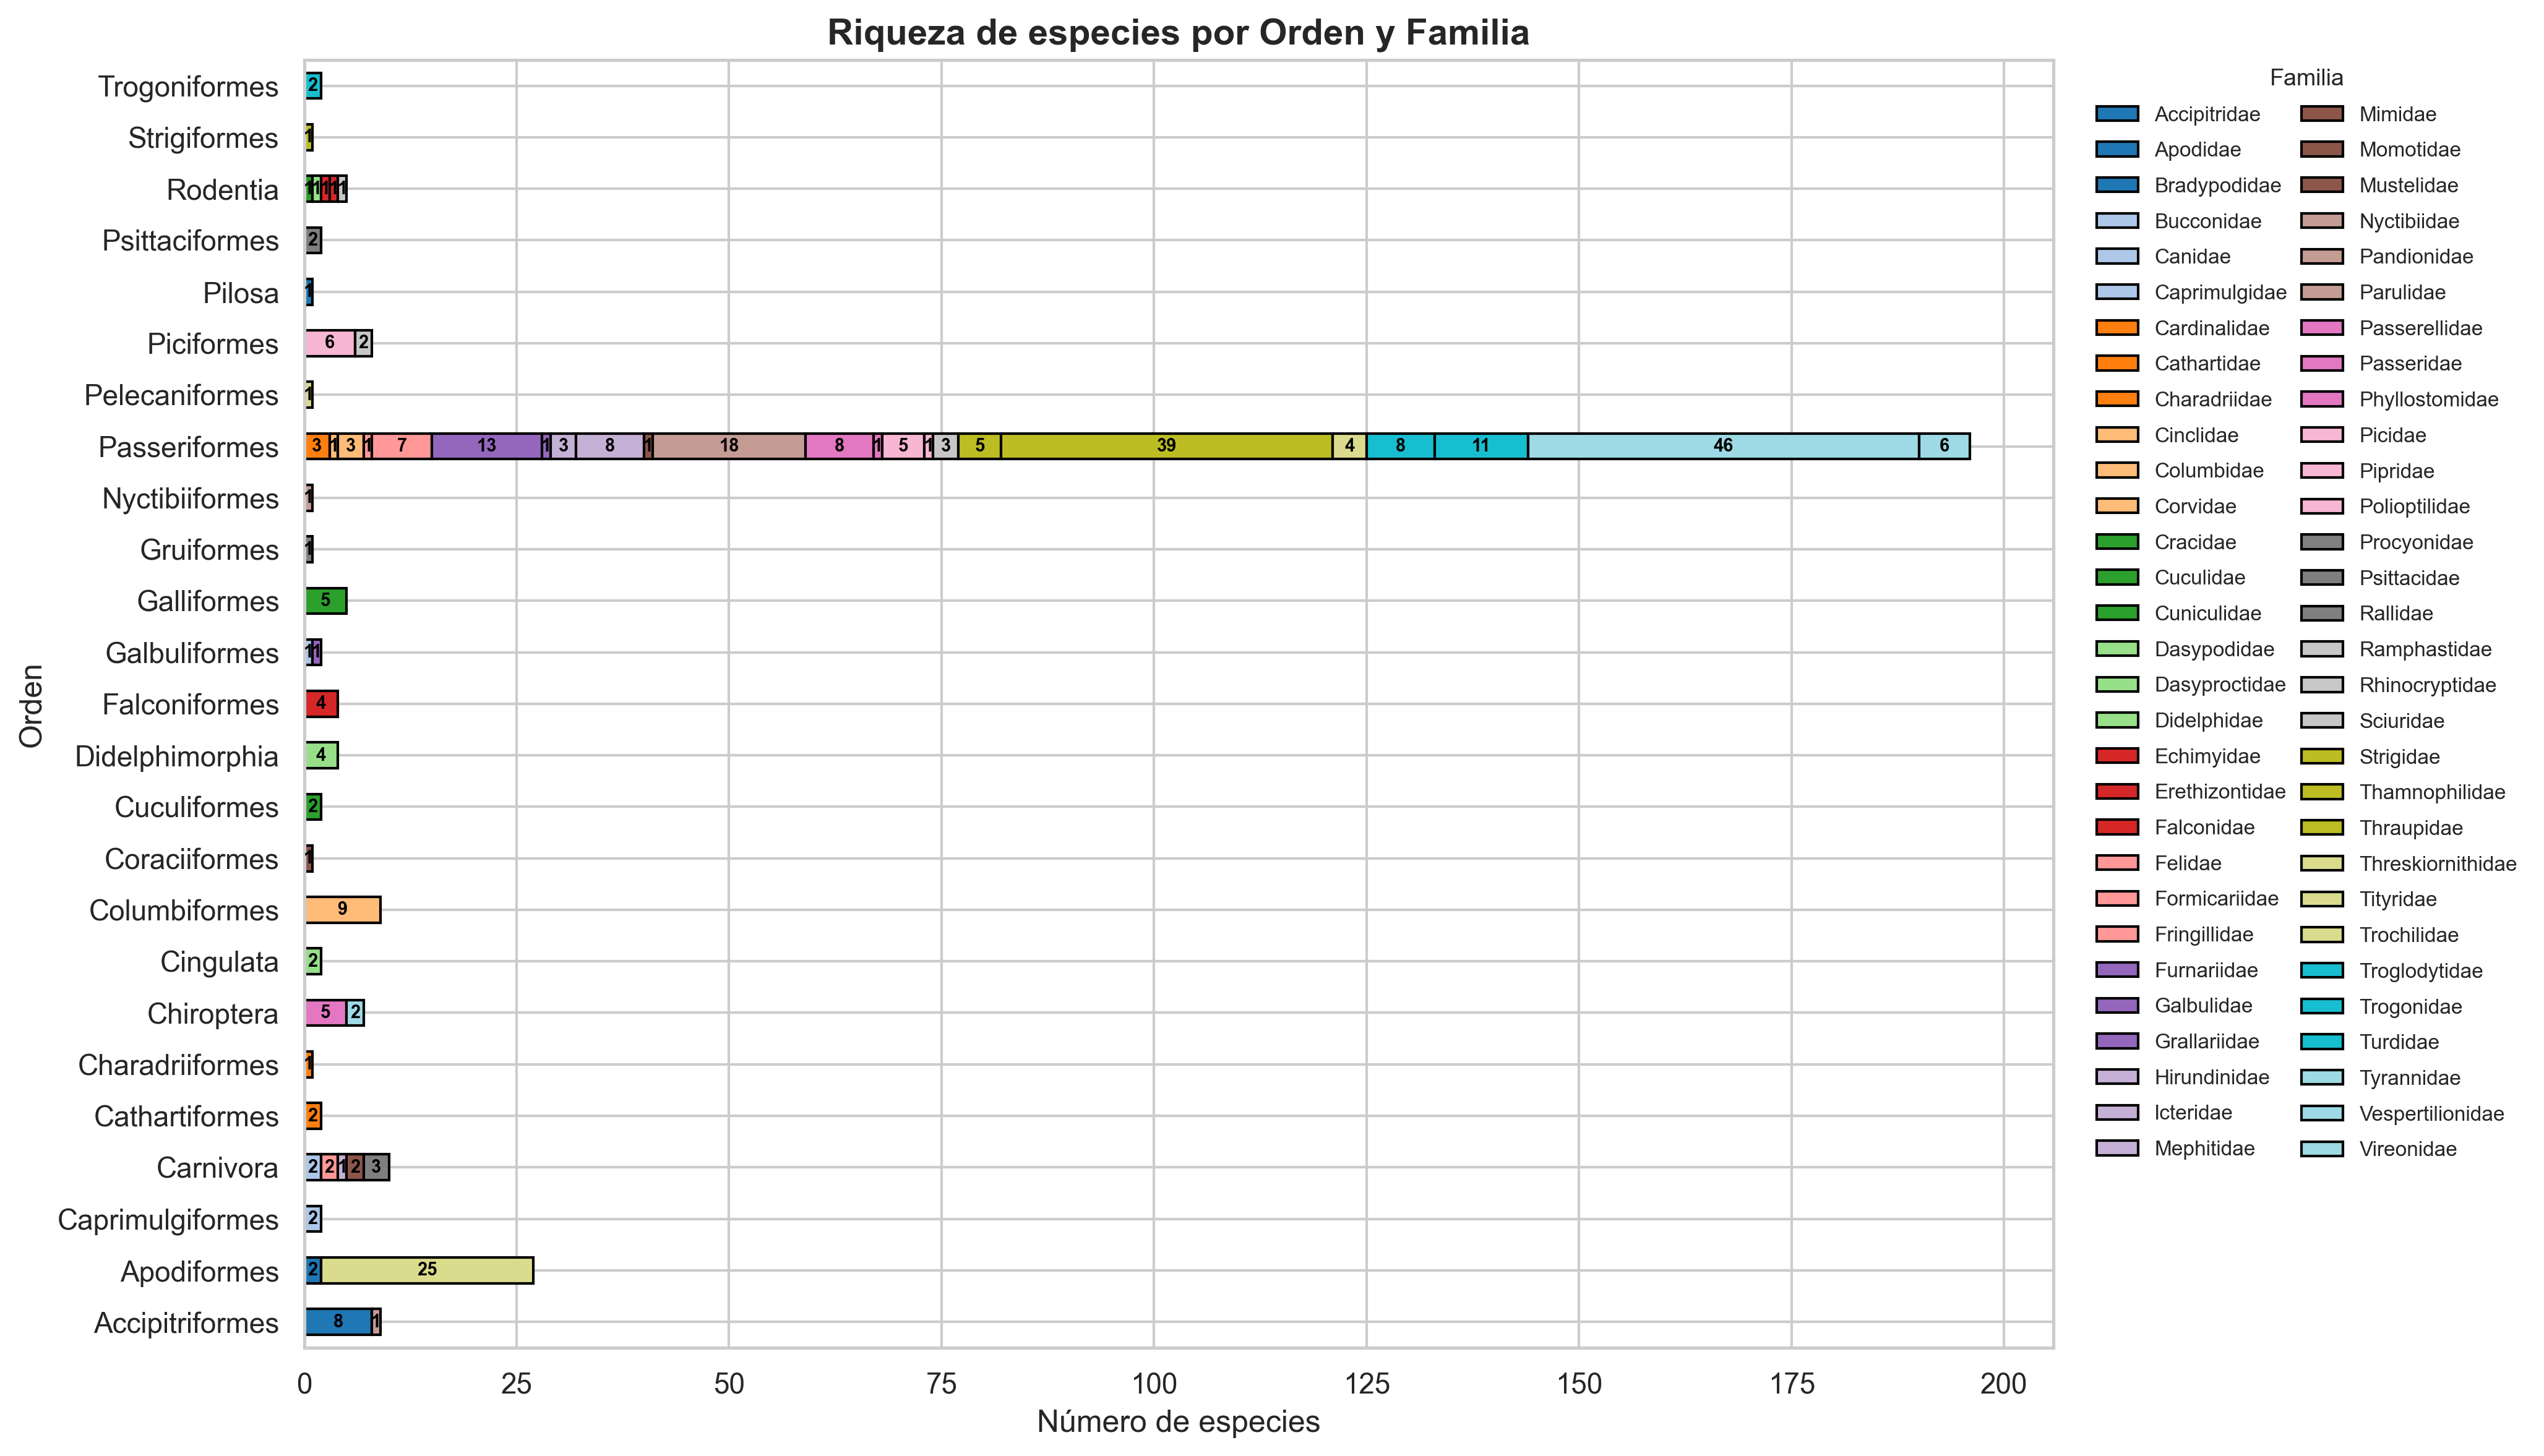

In [3]:
from IPython.display import Image, display, HTML

display(HTML("<h4>Gráfico generado: Riqueza por orden y familia</h4>"))
display(Image(filename=r"D:\CORPONOR 2025\Backet\python_Proyect\Resultados\Grafico_Riqueza_Orden_Familia.png"))


## Curvas de acumulación de especies
En general, para evaluar la representatividad de los muestreos, se empleó la curva de acumulación de especies para cada una de las coberturas muestreadas, que representa el número de especies acumulado en el inventario frente al esfuerzo de muestreo realizado. De esta manera, la curva de acumulación es la representación gráfica de la cantidad de las especies que van apareciendo en el muestreo. Los cálculos se realizaron utilizando R Studio y Python, disponible en línea. Para determinar la eficiencia de estos muestreos, se utilizaron los estimadores como ACE, Chao de primer orden, Jacknife 1 o Bootstrap, los cuales arrojan resultados más precisos al estimar la riqueza de ensamblajes con gran cantidad de especies “raras".


# Riqueza de especies.

Para el presente estudio, la diversidad o riqueza de especies es definida como el número de especies en la zona de estudio, de este modo, y con el fin de hacer una determinación gráfica, se discriminó la totalidad de especies registrados en jerarquías taxonómicas (Orden, Familia, Género, Especie), con el objetivo de identificar el grado de representatividad de cada una.

# Diversidad alfa
Para este análisis se utilizó R Studio y Python con el fin de realiza los análisis de dominancia de Simpson, equitatividad de Pielou y diversidad de Shannon), los cuales nos indican la diversidad de especies de una comunidad particular a la que consideramos homogénea.

## Índice de Simpson (Ds)
Expresa la probabilidad de extraer de la comunidad dos (2) individuos capturados al azar que pertenezcan a la misma especie. Es una medida de cuan dominante es una especie, de esta manera las especies comunes tiene mucho peso respecto a las especies raras. Oscila entre 0 y (1-1/S.

## Índice de Shannon (H´)
El índice de Shannon-Wiener es uno de los índices de medida más simples y de uso más extenso, que mide el grado promedio de incertidumbre para predecir la especie a la que pertenece un individuo dado, elegido al azar dentro de la comunidad. Mide la variedad de especies de un área determinada, indicando su diversidad y frecuencia; una alta diversidad indica un alto grado de desarrollo y estabilidad de la biota; se basa en la abundancia proporcional de las especies como en su riqueza; se incrementa con el número de especies y el número de individuos.

## Índice de equitatividad de Pielou (J)
El Índice de equitatividad de Pielou (J’) mide la proporción de la diversidad observada con relación a la máxima diversidad esperada. Su valor va de cero a uno de forma que uno corresponde a situaciones donde todas las especies son igualmente abundantes. Esta medida al igual que Shannon considera que todas las especies de la comunidad se han contabilizado en la muestra.

## Curvas rango abundancia
Las curvas rango-abundancia se emplearon para comparar la distribución de la abundancia y la uniformidad de las especies entre las diferentes unidades de muestreo. Este tipo de representación permite visualizar tanto la riqueza específica (a partir de la longitud del eje de rango) como la dominancia o equidad en la abundancia de las especies (según la pendiente de la curva). Para facilitar la interpretación y reducir la asimetría de los datos, los valores de abundancia fueron transformados mediante una escala logarítmica de base 10 (log₁₀), lo que permite representar de manera proporcional las diferencias entre especies comunes y raras. Estas curvas son ampliamente utilizadas en estudios de caracterización y estructura de comunidades biológicas, ya que permiten evaluar la composición y el grado de dominancia de los taxones en los distintos hábitats o coberturas analizadas.

## Uso de habitat
Para el análisis del uso de hábitat, se contabilizó el número total de especies registradas en cada cobertura, así como aquellas consideradas exclusivas, es decir, presentes únicamente en una de ellas. Este enfoque permite identificar la representatividad y afinidad de las especies con cada tipo de hábitat, facilitando la comparación de la riqueza y la singularidad biológica entre unidades de muestreo. Las coberturas con mayor número de especies indican una mayor diversidad estructural y funcional del hábitat, mientras que aquellas con un número elevado de especies exclusivas reflejan condiciones particulares que favorecen la presencia de taxones especializados o con requerimientos ecológicos específicos. En conjunto, este análisis ofrece una visión integral sobre cómo las especies utilizan los distintos ambientes disponibles y permite inferir la importancia relativa de cada cobertura en la conservación de la diversidad local.

## Gremios tróficos
Los gremios tróficos se definieron como omnívoro (consumo de material vegetal, animal y alimentos procesados), Insectívoro (consumo de insectos), Folívoro (consumo de hojas), Granívoro (consumo de granos y semillas), Herbívoro (consumo de vegetales), Hematófagos (consumo de sangre), Frugívoro (consumo de frutos), carnívoro (consumo de carne de otros animales), Nectarívoro (consumo del néctar de las flores), Piscívoro (consumo de peces) y Carroñero (consumo de cadáveres de animales). La caracterización trófica, se realizó en base a los resultados de abundancia relativa, para facilitar la cuantificación de la misma.

# Especies de importancia económica y cultural

## Especies sensibles
Posterior a esto, se evaluaron las especies sensibles, Estas especies se reconocen como todas aquellas que, debido a alguna característica ecológica o poblacional, son más perceptivas al cambio ambiental que producen las actividades antrópicas. A partir de esto, fueron analizadas aquellas especies que han sido catalogadas como amenazadas de extinción, para lo cual se tuvieron en cuenta las categorías establecidas a nivel global por la Unión Internacional para la Conservación de la Naturaleza UICN (2021), y a nivel nacional por la Resolución 0126 de 2024 del MADS. Así mismo, se analizaron aquellas especies que presentan restricción en su comercio a través de la lista de la Convención sobre el Comercio Internacional de Especies Amenazadas de Fauna y Flora Silvestres (CITES), aquellas que tuvieran rangos de distribución muy pequeños o restringidos (endémicas) y las especies con algún patrón de migración dentro del territorio, para lo cual fue evaluado el Plan Nacional de especies Migratorias de Naranjo y Amaya y Naranjo et al.   y la Guía de las especies migratorias de la biodiversidad en Colombia de Amaya-Espinel y Zapata.

### UICN

Siguiendo los criterios establecidos por la Unión Internacional para la Conservación de la naturaleza (IUCN), las categorías de amenaza han sido definidas como:

En Peligro Crítico (CR): en esta categoría se incluyen las especies que enfrentan un riesgo extremadamente alto de extinción en estado silvestre, en el futuro inmediato.

En Peligro (EN): esta categoría incluye las especies que no están en “peligro crítico”, pero están enfrentando un muy alto riesgo de extinción o deterioro poblacional en estado silvestre, en el futuro cercano.

Vulnerables (VU): un taxón está en la categoría de VU, cuando la mejor evidencia disponible indica que enfrenta un moderado riesgo de extinción o deterioro poblacional a mediano plazo.

### CITES

Las especies amparadas por la Convención sobre el Comercio Internacional de Especies Amenazadas de Fauna y Flora Silvestres (CITES), se encuentran incluidas en tres apéndices según el grado de protección que necesiten, los cuales se describen a continuación:

Apéndice I: Incluye todas las especies en peligro de extinción, y el comercio de esas especies se autorizará solamente bajo circunstancias excepcionales. 

Apéndice II: Incluye las especies que no se encuentran necesariamente en peligro de extinción, pero cuyo comercio debe controlarse a fin de evitar una utilización incompatible con su supervivencia. 

Apéndice III: Incluye especies que están protegidas al menos en un país, el cual ha solicitado la asistencia de otras partes de las CITES para controlar su comercio.


Los análisis y gráficos se realizaron con los softwares libres R Studio, Python y una hoja de cálculo de Microsoft Excel. 